2021-03-01 19:37:40,774 - INFO - ------------------------------------------------------------------------
2021-03-01 19:37:40,775 - INFO - ------------------Starting the frame CSV parsing process----------------
2021-03-01 19:37:40,776 - INFO - ----------Seting up the environment...
2021-03-01 19:37:40,782 - INFO - ----------Retrieving data...
2021-03-01 19:37:41,195 - INFO - ----------Creating graph...
2021-03-01 19:37:41,260 - INFO - ----------Saving the rendered graphs...
2021-03-01 19:37:42,989 - INFO - ---------------------------Process Finished!!!--------------------------
2021-03-01 19:37:42,990 - INFO - ------------------------------------------------------------------------


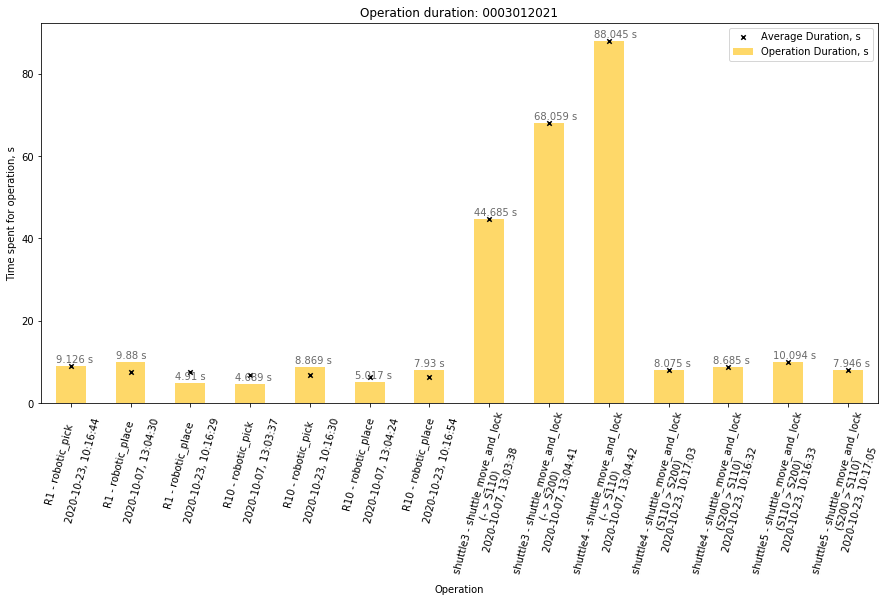

In [3]:
import os
import argparse
import logging
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SparkSession
        
#initial env setup 
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
logging.info("------------------------------------------------------------------------")
logging.info("------------------Starting the frame CSV parsing process----------------")
logging.info("----------Seting up the environment...")
#better display for the dataframe in here!
pd.set_option('display.width', 2000)
parser = argparse.ArgumentParser(description='Job Arguments')
parser.add_argument('--batchID')
args, unknown = parser.parse_known_args()
if args.batchID is None: 
    workingBatch = date.today().strftime("%H%m%d%Y")
else:
    workingBatch = args.batchID
workingPathHDFS = f'/user/akorobeinykov/korobeinykov-{workingBatch}' 
spark = SparkSession.builder.appName("OperationDurationDisplay").master('local').getOrCreate()
sc = SparkContext.getOrCreate()

logging.info("----------Retrieving data...")
df_deltas = spark.sql(f"SELECT * FROM eventDurationHistoryData{workingBatch}").toPandas()
df_avg = spark.sql(f"SELECT * FROM eventDurationHistoryDataAvg").toPandas()
    
#print(df_deltas)  
df_avg = df_deltas.merge(df_avg,on=['operation','details'])
df_avg['operation'] = df_avg['operation'] + df_avg['date_time'].dt.strftime('%Y-%m-%d, %H:%M:%S') 
#print(df_avg)


logging.info("----------Creating graph...")
# Draw a graph with pandas and keep what's returned ,xticks=df1['operation'], thesis-yellow color - color=[(255/256,217/256,105/256)],lw=3
ax = df_avg.plot(kind='scatter', x='operation',y='avg_duration',marker='x',color='black', label='Average Duration, s', zorder=2)
plot2 = df_deltas.plot(ax=ax,y=['duration'],kind='bar',label=['Operation Duration, s'],color=[(255/256,217/256,105/256)],lw=3,figsize=(15,7),zorder=1)
# Set plot parameters

plot2.set_xticks(df_deltas.index)
plot2.set_xticklabels(df_deltas['operation'] +'\n'+ df_deltas['details'] +'\n'+ df_deltas['date_time'].dt.strftime('%Y-%m-%d, %H:%M:%S'),rotation=75)
plot2.set_xlabel("Operation")
plot2.set_ylabel("Time spent for operation, s")
plot2.set_title(f'Operation duration: {workingBatch}')
maxx=df_deltas['duration'].max()
for i in plot2.patches:
    plot2.text(i.get_x(), i.get_height()+maxx*0.01, str(i.get_height())+' s', fontsize=10,color='dimgrey')

# Save plot to filesystem-----------------------------------------------------------------------------------------------------------------------------
logging.info("----------Saving the rendered graphs...")
workingPathOS = f'/home/akorobeinykov/{workingBatch}' 
if not os.path.exists(f'{workingPathOS}/Renders'): 
    os.makedirs(f'{workingPathOS}/Renders')  
plot2.get_figure().savefig(f'{workingPathOS}/Renders/duration-{workingBatch}.png', dpi=300, bbox_inches='tight')


logging.info("---------------------------Process Finished!!!--------------------------")
logging.info("------------------------------------------------------------------------")